# Recovering exact parameters

In [1]:
# These are needed so the git commands below take immediate effect.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoLowRankMultivariateNormal
from pyro.optim import ClippedAdam
from torch.distributions import kl_divergence
from matplotlib import pyplot

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc = {'figure.facecolor': (1, 1, 1, 1)}

In [3]:
class Model:
    def __init__(self, dim, rank):
        self.loc = dist.Laplace(0, 1).sample([dim])
        self.cov_factor = torch.randn(dim, rank)
        self.cov_diag = dist.Exponential(1).sample([dim])
        
    def get_prior(self):
        return dist.LowRankMultivariateNormal(
            self.loc, self.cov_factor, self.cov_diag)
        
    def __call__(self):
        pyro.sample("z", self.get_prior())

In [4]:
def train(dim, rank):
    pyro.clear_param_store()
    pyro.set_rng_seed(123456789)
    model = Model(dim, rank)
    guide = AutoLowRankMultivariateNormal(model, rank=rank, init_scale=0.01)
    optim = ClippedAdam({"lr": 0.01})
    elbo = Trace_ELBO()
    svi = SVI(model, guide, optim, elbo)
    losses = []
    kls = []
    for step in range(2001):
        loss = svi.step() / dim
        with torch.no_grad():
            kl = kl_divergence(guide.get_posterior(), model.get_prior()).item()
        losses.append(loss)
        kls.append(kl)
        if step % 200 == 0:
            print("step {: >4} loss = {:0.8g}, kl = {:0.8g}".format(step, loss, kl))
    return losses, kls

In [5]:
results = {}

In [6]:
!(cd ~/pyro ; git checkout dev)

Switched to branch 'dev'
Your branch is up-to-date with 'origin/dev'.


In [7]:
results["dev-10-3"] = train(10, 3)
results["dev-100-10"] = train(100, 10)
results["dev-1000-30"] = train(1000, 30)

step    0 loss = 4.638187, kl = 43.23119
step  200 loss = 2.8728124, kl = 25.555887
step  400 loss = 1.7525949, kl = 17.784056
step  600 loss = 0.82459812, kl = 10.531194
step  800 loss = 0.32042284, kl = 4.7951403
step 1000 loss = 0.058632278, kl = 1.9261093
step 1200 loss = 0.11942101, kl = 1.1758461
step 1400 loss = 0.079623985, kl = 1.2316513
step 1600 loss = 0.11938505, kl = 1.1139026
step 1800 loss = 0.17719917, kl = 1.1312404
step 2000 loss = 0.17642403, kl = 1.0629854
step    0 loss = 7.3285764, kl = 715.05151
step  200 loss = 3.1977349, kl = 337.80298
step  400 loss = 2.2628703, kl = 227.29871
step  600 loss = 1.3797719, kl = 138.97552
step  800 loss = 0.62398743, kl = 65.546707
step 1000 loss = 0.32295372, kl = 28.676758
step 1200 loss = 0.25201462, kl = 22.879364
step 1400 loss = 0.19924316, kl = 21.936577
step 1600 loss = 0.2244397, kl = 20.902061
step 1800 loss = 0.23091187, kl = 19.515343
step 2000 loss = 0.11512756, kl = 18.84201
step    0 loss = 7.6754194, kl = 7567.065

In [8]:
!(cd ~/pyro ; git checkout auto-lowrank-mvn-reparam)

Switched to branch 'auto-lowrank-mvn-reparam'


In [9]:
results["new-10-3"] = train(10, 3)
results["new-100-10"] = train(100, 10)
results["new-1000-30"] = train(1000, 30)

step    0 loss = 4.5021383, kl = 44.462814
step  200 loss = 2.4963582, kl = 21.211407
step  400 loss = 0.44209099, kl = 5.1787424
step  600 loss = 0.088971138, kl = 1.4138136
step  800 loss = 0.11571178, kl = 0.84105682
step 1000 loss = 0.047342205, kl = 0.43220854
step 1200 loss = -0.015056038, kl = 0.44497108
step 1400 loss = -0.075518131, kl = 0.47824335
step 1600 loss = 0.019918633, kl = 0.31288815
step 1800 loss = 0.13250313, kl = 0.31512117
step 2000 loss = 0.047943306, kl = 0.21335554
step    0 loss = 7.0968411, kl = 701.02686
step  200 loss = 2.2128764, kl = 225.05743
step  400 loss = 0.53202805, kl = 53.576309
step  600 loss = 0.23050415, kl = 23.27948
step  800 loss = 0.074443665, kl = 18.650421
step 1000 loss = 0.13672592, kl = 15.877785
step 1200 loss = 0.14218384, kl = 14.164749
step 1400 loss = 0.065524292, kl = 12.89175
step 1600 loss = 0.15202454, kl = 12.087418
step 1800 loss = 0.13887268, kl = 10.916183
step 2000 loss = 0.049367676, kl = 10.265976
step    0 loss = 7.3

In [11]:
def plot(dim, rank):
    pyplot.figure(figsize=(9,3))
    for name, (losses, kls) in sorted(results.items()):
        if name.endswith(f"-{dim}-{rank}"):
            pyplot.plot(kls, label=name)
    pyplot.title(f"dim={dim} rank={rank}")
    pyplot.ylabel('kl(q,p)')
    pyplot.yscale('log')
    pyplot.xlabel('svi step')
    pyplot.legend()
    pyplot.tight_layout()

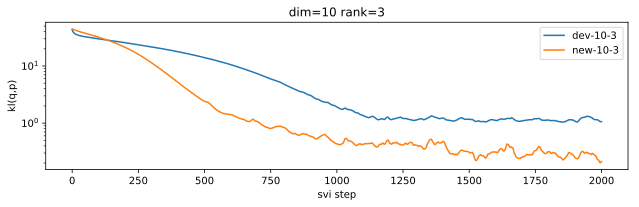

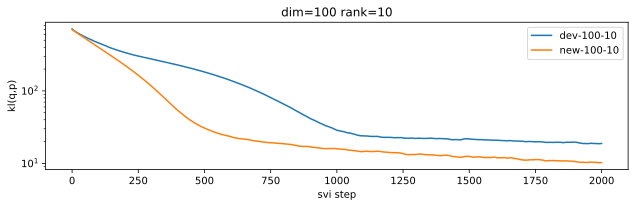

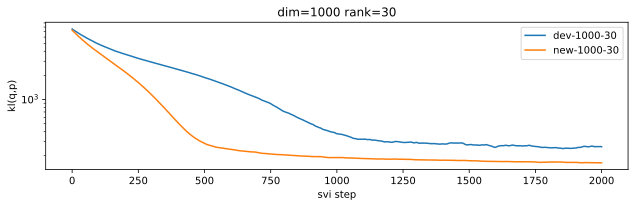

In [12]:
plot(10, 3)
plot(100, 10)
plot(1000, 30)